# 08d – New Endoscopy Site Selection

This notebook identifies optimal new locations for endoscopy capacity to address areas with **Low** or **Marginal** access (i.e., <4.0 rooms per 100,000 people aged 50–74). We implement and compare two strategies:

---

## Spatial Clustering (DBSCAN or Hexbin)

**Plain English Description:**
This method identifies clusters of underserved LSOAs (based on location, population, and access score) using spatial clustering techniques like **DBSCAN** or **hexbin aggregation**. A new site is proposed at the centroid of each cluster.

**Rationale:**
- Targets groups of underserved areas rather than single extremes.
- Prioritises consistent spatial gaps, especially in rural or edge-of-region zones.
- Clustering avoids over-concentrating new sites in dense urban cores.

---

In [21]:
# ----------------------------------------------------------
# Step 0 – Imports and File Paths
# ----------------------------------------------------------

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

# Set plot style
plt.style.use("seaborn-v0_8-whitegrid")

# Define base and sub-directory paths
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
raw_dir = os.path.join(data_dir, "raw")
proc_dir = os.path.join(data_dir, "processed", "endoscopy")

# Define input file paths
gpkg_path = os.path.join(raw_dir, "LSOA_5-year_segment_master.gpkg")
access_path = os.path.join(proc_dir, "lsoa_competition_access.gpkg")
travel_path = os.path.join(proc_dir, "travel_times_filtered.csv")
facilities_path = os.path.join(proc_dir, "facilities_with_geometry.gpkg")
travel_csv_path = os.path.join(raw_dir, "LSOA_to_LSOA_complete.csv")

# Load data
access_gdf = gpd.read_file(access_path)
lsoa_gdf = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]]

# CRS alignment
access_gdf = access_gdf.to_crs(lsoa_gdf.crs)

# Filter underserved LSOAs (Low or Marginal access)
underserved_gdf = access_gdf[access_gdf["access_flag"].isin(["Low", "Marginal"])].copy()

# Merge geometry onto underserved areas
underserved_gdf = underserved_gdf.merge(
    lsoa_gdf,
    on="lsoa21cd",
    how="left"
)

# Merge geometry onto underserved areas
underserved_gdf = underserved_gdf.merge(
    lsoa_gdf,
    on="lsoa21cd",
    how="left"
)

# Set correct geometry column
underserved_gdf = underserved_gdf.set_geometry("geometry")

# Reproject to British National Grid for clustering
underserved_gdf = underserved_gdf.to_crs(epsg=27700)


# Preview
print(f"Underserved LSOAs loaded: {underserved_gdf.shape[0]}")
underserved_gdf[["lsoa21cd", "rooms_per_100k_competition", "access_flag"]].head()


Underserved LSOAs loaded: 1865


,lsoa21cd,rooms_per_100k_competition,access_flag
0,E01015406,2.227723,Low
1,E01015459,2.227723,Low
2,E01015404,2.227723,Low
3,E01015455,2.227723,Low
4,E01015370,2.227723,Low


## Step 1a – Preview Map of Underserved LSOAs (Low + Marginal Access)

Before applying DBSCAN clustering, we visualise the spatial distribution of underserved LSOAs across the NHS South West region.

This helps confirm:
- That underserved areas form potential clusters
- The spread across urban/rural settings
- Any edge effects (e.g. eastern boundary LSOAs near other NHS regions)

The map colours LSOAs by access flag (`Low`, `Marginal`) and overlays existing facility locations.


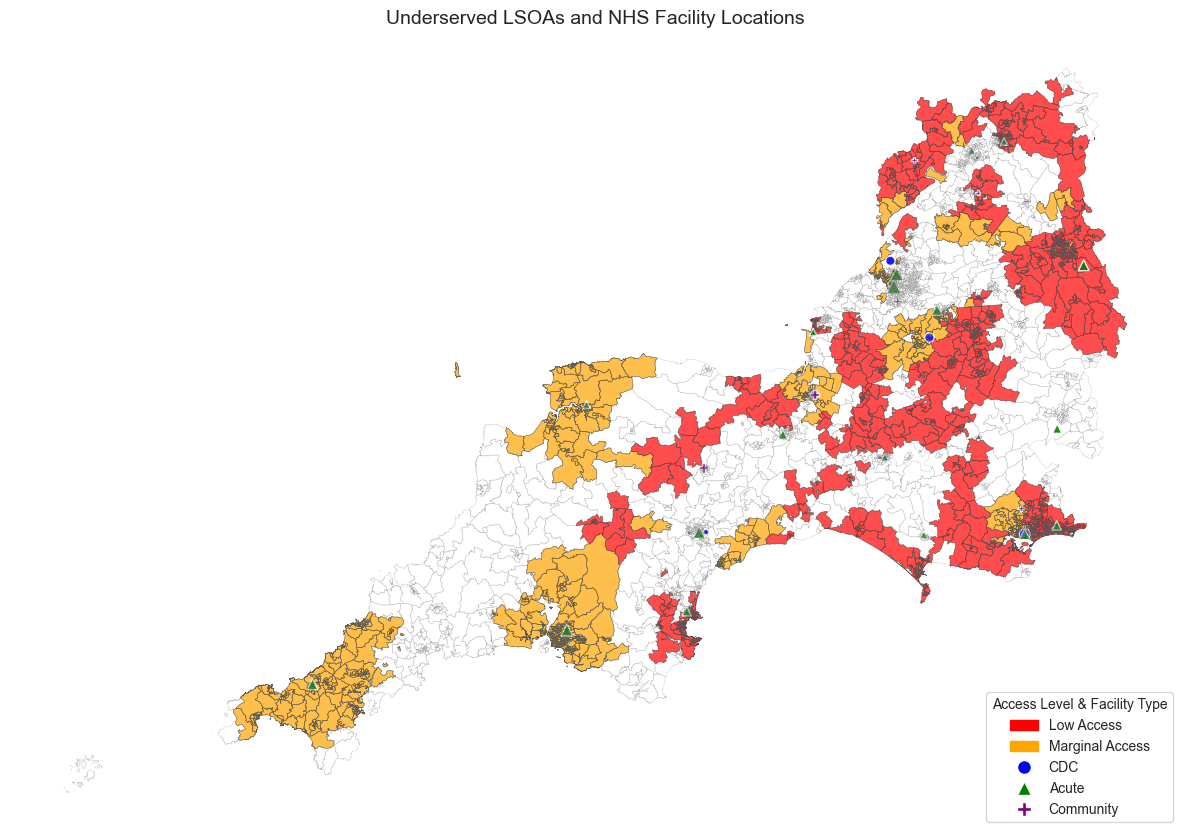

In [8]:
# ----------------------------------------------------------
# Step 1a – Visual Preview: Underserved LSOAs + NHS Facilities
# ----------------------------------------------------------

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Reproject facility and boundary data to match
facilities_gdf = gpd.read_file(facilities_path).to_crs(epsg=27700)
lsoa_borders = lsoa_gdf.to_crs(epsg=27700).boundary

# Create colour map for access types
cmap = ListedColormap(["red", "orange"])
access_order = ["Low", "Marginal"]
underserved_gdf["access_code"] = underserved_gdf["access_flag"].map({"Low": 0, "Marginal": 1})

# Set up plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot underserved LSOAs (categorical)
underserved_gdf.plot(
    ax=ax,
    column="access_code",
    cmap=cmap,
    linewidth=0.3,
    edgecolor="black",
    alpha=0.7,
    legend=False
)

# Overlay LSOA borders
lsoa_borders.plot(
    ax=ax,
    linewidth=0.3,
    color="grey",
    alpha=0.4
)

# Overlay NHS facilities by type
for label, colour, marker in [("CDC", "blue", "o"), ("Acute", "green", "^"), ("Community", "purple", "P")]:
    subset = facilities_gdf[facilities_gdf["source"] == label]
    subset.plot(
        ax=ax,
        color=colour,
        markersize=subset["Endoscopy Rooms"] * 15,
        marker=marker,
        label=label,
        alpha=0.9,
        edgecolor="white"
    )

# Custom legend
access_patches = [
    mpatches.Patch(color='red', label='Low Access'),
    mpatches.Patch(color='orange', label='Marginal Access')
]
ax.legend(
    handles=access_patches + [plt.Line2D([0], [0], marker=mk, color='w',
              markerfacecolor=col, markersize=10, label=lbl)
              for lbl, col, mk in [("CDC", "blue", "o"), ("Acute", "green", "^"), ("Community", "purple", "P")]],
    title="Access Level & Facility Type",
    loc="lower right",
    frameon=True
)

# Final formatting
ax.set_title("Underserved LSOAs and NHS Facility Locations", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


## Step 2 – Apply DBSCAN to Identify Clusters of Underserved LSOAs

We apply DBSCAN (Density-Based Spatial Clustering of Applications with Noise) to the underserved LSOAs, using their centroids as input coordinates.

**Key parameters**:
- `eps = 10,000` metres (10 km neighbourhood)
- `min_samples = 5` LSOAs to form a cluster

DBSCAN is well-suited for spatial clustering with:
- Irregular cluster shapes (urban & rural)
- Anomalies or isolated LSOAs near region edges


In [10]:
# ----------------------------------------------------------
# Step 2 – Filter, Cluster, and Package Underserved LSOAs
# ----------------------------------------------------------


from sklearn.cluster import DBSCAN
import numpy as np

# Filter for underserved LSOAs with at least some target-age population
filtered_gdf = underserved_gdf[underserved_gdf["pop_50_74"] > 0].copy()

# Convert to centroids and extract X/Y coords
filtered_gdf["centroid"] = filtered_gdf.geometry.centroid
coords = np.array(list(filtered_gdf["centroid"].apply(lambda p: (p.x, p.y))))

# Apply DBSCAN (10 km eps, min 5 LSOAs)
db = DBSCAN(eps=10_000, min_samples=5, metric="euclidean")
filtered_gdf["cluster"] = db.fit_predict(coords)

# Filter to actual clusters (exclude noise)
clustered_gdf = filtered_gdf[filtered_gdf["cluster"] != -1].copy()

# Preview summary
print(f"Total clusters found: {clustered_gdf['cluster'].nunique()}")
print(f"LSOAs assigned to clusters: {clustered_gdf.shape[0]}")


Total clusters found: 7
LSOAs assigned to clusters: 1859


In [13]:
# Store per-cluster LSOA groupings in a dictionary
cluster_lsoa_lookup = {
    c: df.reset_index(drop=True)
    for c, df in clustered_gdf.groupby("cluster")
}

# Example: View cluster 0
cluster_lsoa_lookup[0][["lsoa21cd", "pop_50_74", "access_flag"]].head()


,lsoa21cd,pop_50_74,access_flag
0,E01015406,620.73,Low
1,E01015459,748.96,Low
2,E01015404,743.86,Low
3,E01015455,717.41,Low
4,E01015370,534.24,Low


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_7056/272402631.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab20", n_clusters)


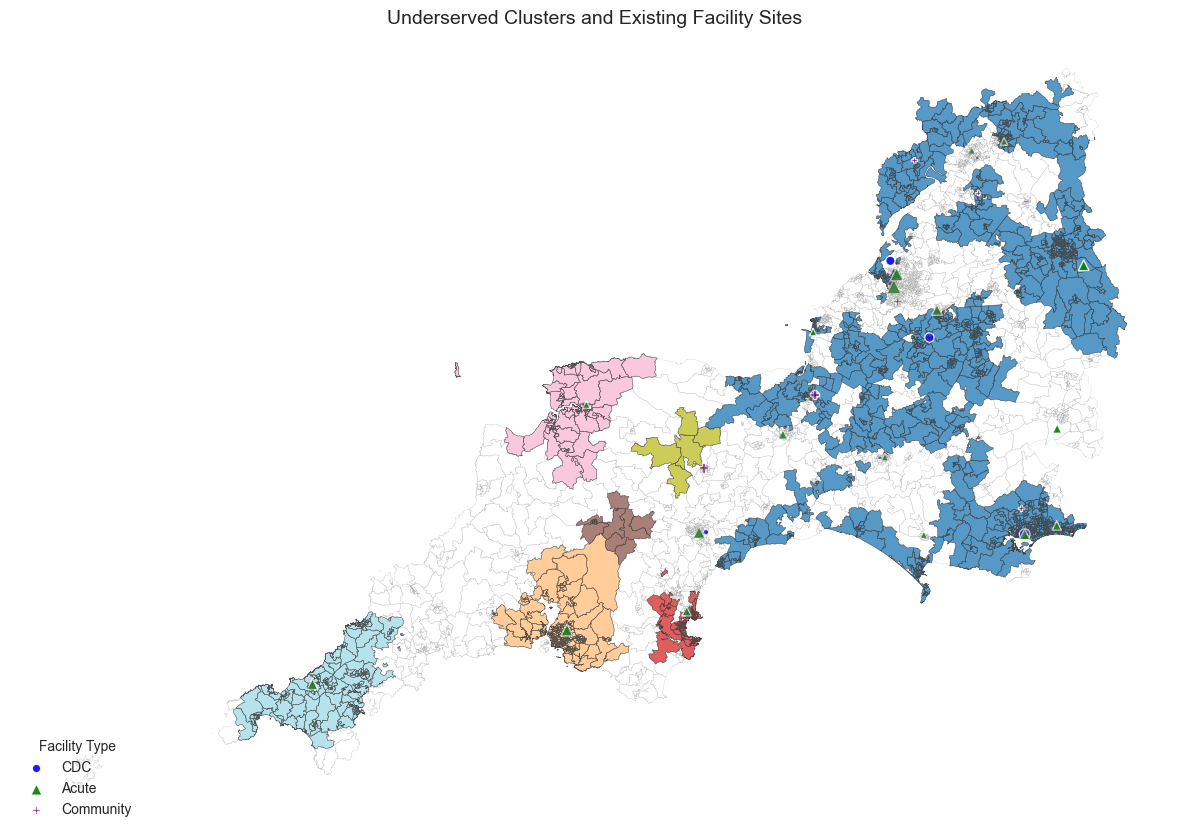

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# Set up figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot clustered LSOAs with unique cluster colours (but no colourbar)
unique_clusters = clustered_gdf["cluster"].unique()
n_clusters = len(unique_clusters)
cmap = cm.get_cmap("tab20", n_clusters)
norm = colors.BoundaryNorm(boundaries=np.arange(-0.5, n_clusters + 0.5, 1), ncolors=n_clusters)

clustered_gdf.plot(
    ax=ax,
    column="cluster",
    cmap=cmap,
    norm=norm,
    legend=False,  # Turn off colourbar
    edgecolor="black",
    linewidth=0.3,
    alpha=0.75
)

# Add base boundary layer
lsoa_gdf.to_crs(epsg=27700).boundary.plot(
    ax=ax,
    linewidth=0.3,
    color="grey",
    alpha=0.3
)

# Overlay facility site markers by source
for label, colour, marker in [("CDC", "blue", "o"), ("Acute", "green", "^"), ("Community", "purple", "P")]:
    subset = facilities_gdf[facilities_gdf["source"] == label].to_crs(epsg=27700)
    subset.plot(
        ax=ax,
        color=colour,
        markersize=subset["Endoscopy Rooms"] * 15,
        marker=marker,
        label=label,
        alpha=0.9,
        edgecolor="white"
    )

# Format and show
ax.set_title("Underserved Clusters and Existing Facility Sites", fontsize=14)
ax.legend(title="Facility Type", loc="lower left")
ax.axis("off")
plt.tight_layout()
plt.show()


In [24]:
# ----------------------------------------------------------
# Step 2b – Identify Optimal LSOA per Cluster Using Travel Time
# ----------------------------------------------------------

# Load travel time matrix (already done if not, re-run this)
travel_df = pd.read_csv(travel_csv_path)

# Initialise list to store best LSOA per cluster
optimal_sites = []

# Iterate through clusters
for cluster_id, df in cluster_lsoa_lookup.items():
    lsoa_list = df["lsoa21cd"].tolist()

    # Filter only within-cluster travel times (car only)
    cluster_travel = travel_df[
        (travel_df["origin_name"].isin(lsoa_list)) &
        (travel_df["destination_name"].isin(lsoa_list))
    ]

    # Sum travel time from each origin to all other destinations
    total_travel = (
        cluster_travel.groupby("origin_name")["travel_time_car"]
        .sum()
        .reset_index()
        .rename(columns={"origin_name": "lsoa21cd", "travel_time_car": "total_cluster_travel_time"})
    )

    # Merge back to original LSOA geometry
    best_lsoa = (
        total_travel.merge(df, on="lsoa21cd", how="left")
        .sort_values("total_cluster_travel_time")
        .iloc[0]
    )

    # Store result
    optimal_sites.append({
        "cluster": cluster_id,
        "lsoa21cd": best_lsoa["lsoa21cd"],
        "travel_time_sum": best_lsoa["total_cluster_travel_time"],
        "pop_50_74": best_lsoa["pop_50_74"],
        "geometry": best_lsoa["geometry"]
    })

# Convert results to GeoDataFrame
optimal_sites_gdf = gpd.GeoDataFrame(optimal_sites, geometry="geometry", crs=clustered_gdf.crs)

# Preview result
print(optimal_sites_gdf[["cluster", "lsoa21cd", "travel_time_sum", "pop_50_74"]].head())



   cluster   lsoa21cd  travel_time_sum  pop_50_74
0        0  E01029023     83415.543571     527.12
1        1  E01015103      2912.518889     481.33
2        2  E01015224      1070.955005     598.35
3        3  E01020328        92.499684     676.71
4        4  E01020096      1248.037335     526.10


In [26]:
# Convert to DataFrame
optimal_sites_df = pd.DataFrame(optimal_sites)

# Join back to get centroid X/Y coordinates for each selected LSOA
optimal_sites_df = optimal_sites_df.merge(
    clustered_gdf[["lsoa21cd", "centroid"]], 
    on="lsoa21cd", 
    how="left"
)

# Extract X/Y for plotting
optimal_sites_df["centroid_x"] = optimal_sites_df["centroid"].apply(lambda p: p.x)
optimal_sites_df["centroid_y"] = optimal_sites_df["centroid"].apply(lambda p: p.y)


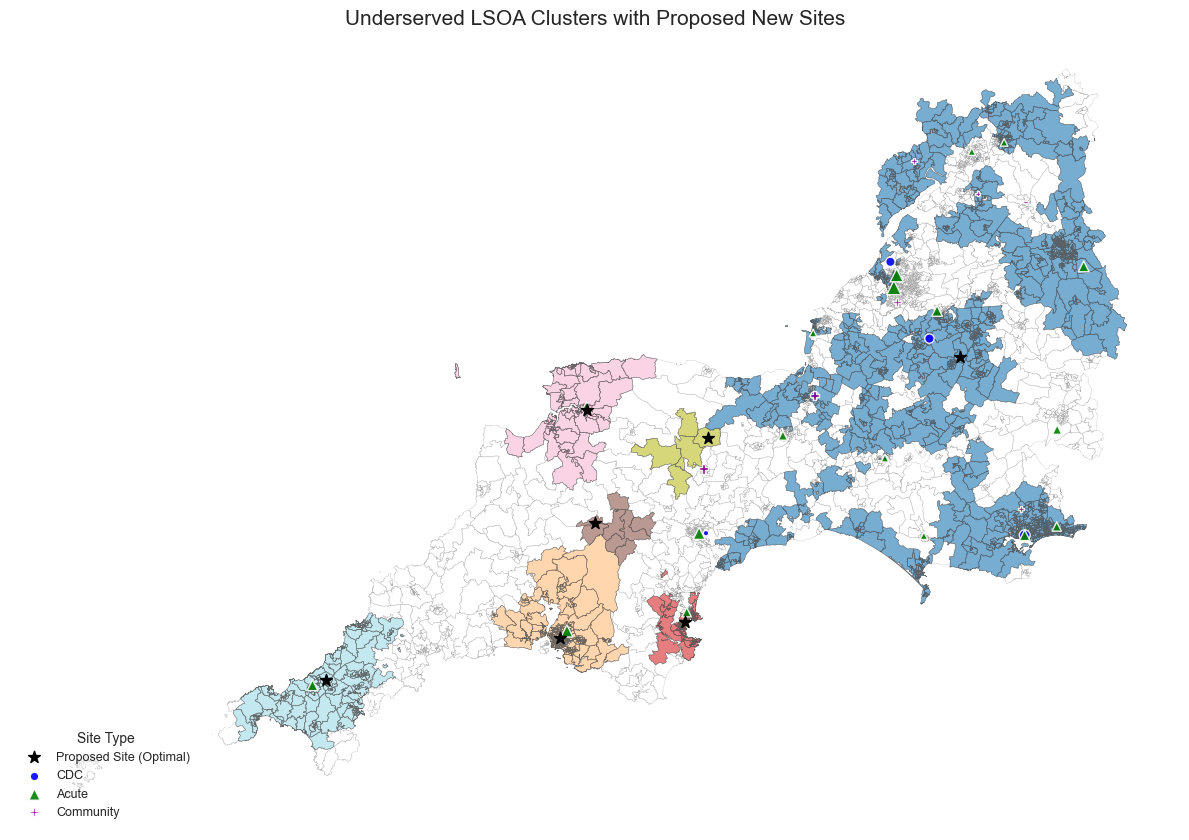

In [27]:
# ----------------------------------------------------------
# Step 2c – Map Optimal LSOA Sites onto Clusters
# ----------------------------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(12, 14))

# 1. Plot all clustered underserved LSOAs, coloured by cluster ID
clustered_gdf.plot(
    ax=ax,
    column="cluster",
    cmap="tab20",
    linewidth=0.3,
    edgecolor="black",
    legend=False,
    alpha=0.6
)

# 2. Plot proposed optimal LSOA sites
gpd.GeoDataFrame(
    optimal_sites_df,
    geometry=gpd.points_from_xy(optimal_sites_df["centroid_x"], optimal_sites_df["centroid_y"]),
    crs="EPSG:27700"
).plot(
    ax=ax,
    color="black",
    markersize=80,
    marker="*",
    label="Proposed Site (Optimal)",
    zorder=3
)

# 3. Plot current facility sites
for label, colour, marker in [("CDC", "blue", "o"), ("Acute", "green", "^"), ("Community", "purple", "P")]:
    subset = facilities_gdf[facilities_gdf["source"] == label]
    subset.plot(
        ax=ax,
        color=colour,
        markersize=subset["Endoscopy Rooms"] * 15,
        marker=marker,
        label=label,
        alpha=0.9,
        edgecolor="white",
        zorder=2
    )

# 4. Base map boundary
lsoa_gdf.to_crs(epsg=27700).boundary.plot(
    ax=ax,
    linewidth=0.3,
    color="grey",
    alpha=0.4,
    zorder=1
)

# 5. Formatting
ax.set_title("Underserved LSOA Clusters with Proposed New Sites", fontsize=15)
ax.axis("off")
ax.legend(loc="lower left", fontsize=9, title="Site Type")
plt.tight_layout()
plt.show()


In [30]:
# ----------------------------------------------------------
# Step 3 – Create Uplift File from Proposed Sites (7x Clusters)
# ----------------------------------------------------------

# 1. Load geometry source (LSOA geometries)
lsoa_geom = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]].to_crs(epsg=27700)

# 2. Merge geometry onto optimal_sites_df
optimal_sites_df = optimal_sites_df.merge(
    lsoa_geom,
    on="lsoa21cd",
    how="left"
)

# 3. Create GeoDataFrame (geometry column now present)
proposed_gdf = gpd.GeoDataFrame(
    optimal_sites_df.copy(),
    geometry="geometry",
    crs="EPSG:27700"
)

# 4. Add standardised facility fields
proposed_gdf["Code"] = ["PROPOSED_" + str(i) for i in proposed_gdf.index]
proposed_gdf["Name"] = "Proposed Site Cluster " + proposed_gdf["cluster"].astype(str)
proposed_gdf["Endoscopy Rooms"] = 1
proposed_gdf["postcode"] = "TBC"
proposed_gdf["latitude"] = proposed_gdf.geometry.centroid.y
proposed_gdf["longitude"] = proposed_gdf.geometry.centroid.x
proposed_gdf["msoa21cd"] = "TBC"
proposed_gdf["oa21cd"] = "TBC"
proposed_gdf["icb_code"] = "TBC"
proposed_gdf["local_authority"] = "TBC"
proposed_gdf["source"] = "Proposed"

# 5. Reorder columns
proposed_gdf = proposed_gdf[
    ["Code", "Name", "Endoscopy Rooms", "postcode", "latitude", "longitude",
     "lsoa21cd", "msoa21cd", "oa21cd", "icb_code", "local_authority",
     "source", "geometry"]
]

# 6. Preview
print("Proposed uplift sites created:", proposed_gdf.shape[0])
display(proposed_gdf.head(2))


Proposed uplift sites created: 7


,Code,Name,Endoscopy Rooms,postcode,latitude,longitude,lsoa21cd,msoa21cd,oa21cd,icb_code,local_authority,source,geometry
0,PROPOSED_0,Proposed Site Cluster 0,1,TBC,150291.713366,380516.472326,E01029023,TBC,TBC,TBC,TBC,Proposed,"MULTIPOLYGON (((380077.313 152842.094, 380082...."
1,PROPOSED_1,Proposed Site Cluster 1,1,TBC,57186.947749,247659.826676,E01015103,TBC,TBC,TBC,TBC,Proposed,"MULTIPOLYGON (((247818.797 57407.051, 247822.7..."


In [31]:
# 1. Concatenate original and proposed facilities
all_facilities_gdf = pd.concat(
    [facilities_gdf, proposed_gdf],
    ignore_index=True
)

# 2. Check result
print(f"Total combined facilities: {all_facilities_gdf.shape[0]}")
print(all_facilities_gdf["source"].value_counts())  # Should include 'CDC', 'Acute', 'Community', 'Proposed'


Total combined facilities: 39
source
Acute        18
CDC           7
Community     7
Proposed      7
Name: count, dtype: int64


In [32]:
# 1. Define output path
uplift_path = os.path.join(proc_dir, "facilities_with_proposed_sites.gpkg")

# 2. Save to GeoPackage
all_facilities_gdf.to_file(uplift_path, driver="GPKG")

# 3. Confirm write success
print(f"Combined facility file saved to: {uplift_path}")


Combined facility file saved to: /Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/endoscopy/facilities_with_proposed_sites.gpkg
